In [10]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Hyper-parameter optimization with Grid search 
This notebook is an illustrative example of how to use grid search functionality in Darts to optimize a forecasting model's hyperparameters. 

Grid search simply creates as many models as there are hyper-parameter combinations, fits a model with each one of those combinations and then compares them based on a validation set and a relevant metric. 

In Darts, all forecasting models hyper-paramters can be optimized using grid search by calling the static method <code>[MODELCLASS.gridsearch()](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.forecasting_model.html?highlight=gridsearch#darts.models.forecasting.forecasting_model.GlobalForecastingModel.gridsearch)</code>, for example <code>LightGBMModel.gridsearch()</code>. However, for models with hyper-parameters that are not easily discretizable (e.g., learning rates in optimization algorithms) or with a large number of possible values/combinations (e.g., width and depth of neural networks) grid search is not recommended. Instead we advise the reader to look at more advanced methods like [Optuna and Ray Tune](https://unit8co.github.io/darts/userguide/hyperparameter_optimization.html).

We will also showcase four different models : DLinear, NLinear, FourTheta and LightGBM.  

In [1]:
import numpy as np
import pandas as pd
from darts.datasets import EnergyDataset, WineDataset, MonthlyMilkDataset
from darts.utils.statistics import plot_pacf
from darts.models import LightGBMModel, FourTheta, DLinearModel, NLinearModel
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from statsmodels.tsa.stattools import pacf
from darts.metrics import mae, mape, rmse, r2_score, mase, smape
import matplotlib.pyplot as plt
from darts.utils.utils import ModelMode, SeasonalityMode, TrendMode

In [2]:
def display_forecast(pred_series, ts_transformed, forecast_type, start_date=None, metric = rmse):
    plt.figure(figsize=(8, 5))
    if start_date:
        ts_transformed = ts_transformed.drop_before(start_date)
    ts_transformed.univariate_component(0).plot(label="actual")
    pred_series.plot(label=(forecast_type + " forecasts"))
    plt.title(
        "{}: {}".format(metric.__name__, metric(ts_transformed.univariate_component(0), pred_series))
    )
    plt.legend()

In [3]:
def get_lags(data, max_lag = 24, method = "ywadjusted", alpha = 0.05):
    r, confint = pacf(data.values(), nlags=max_lag, method=method, alpha=alpha)
    r = np.array(r)
    upp_band = [confint[lag][1] - r[lag] for lag in range(1, max_lag + 1)]
    lags = np.where(abs(r[1:])>upp_band)[0]+1
    lags = [int(lag)*-1 for lag in lags if lag < max_lag//2]
    return lags
    

## NLinear and DLinear models 
These two models are simple fully connected neural network models with only one layer and no activation functions (i.e., no non-linearity). Since no activation functions are used, the output of those models are simply linear combinations of the inputs with weights learned by gradient descent. . We will showcase how to use them and, given their simplicity, optimize some of their hyperparameters with a grid search procedure. 
The main difference between the NLinear and the DLinear is that DLinear first extracts a linear trend by computing a weighted (i.e., kernel) moving average on the series and a fully connected layer is applied to both the trend and the detrended data. DLinear should be able to better represent other components than the trend which might remain dominant in NLinear. Hence, a hypothesis to verify with hyper-parameter optimization is whether NLinear benefits more from shorter insight into the past (i.e., shorter <code>input_chunk_length</code>) while DLinear might benefit from the opposite (i.e., longer <code>input_chunk_length</code>). (DOES NOT LOOK LIKE IT'S THE CASE, BUT THEN I DON?T UNDER)

We load the EnergyDataset available in Darts. For the purposes of this notebook, we will only take one component from this series and look at the series "generation hydro run-of-river and poundage". We start by transforming this series from an hourly frequency to a daily frequency by averaging the values of the series over the total hours of the day. A missing value tranformer is applied first, followed by a Min-Max scaler. We then split the data into traning and validation sets. 

In [4]:
original_df = EnergyDataset().load().pd_dataframe()
original_df["generation hydro run-of-river and poundage"].plot()
plt.title("Hourly generation hydro run-of-river and poundage")

Text(0.5, 1.0, 'Hourly generation hydro run-of-river and poundage')

In [5]:
df_day_avg = original_df.groupby(original_df.index.astype(str).str.split(" ").str[0]).mean().reset_index()
filler = MissingValuesFiller()
scaler = Scaler()
series = scaler.fit_transform(
    filler.transform(
        TimeSeries.from_dataframe(
            df_day_avg, "time", ["generation hydro run-of-river and poundage"]
        )
    )
).astype(np.float32)
series.plot()
plt.title("Daily generation hydro run-of-river and poundage")

Text(0.5, 1.0, 'Daily generation hydro run-of-river and poundage')

In [6]:
train, val = series.split_after(pd.Timestamp("20180101"))

We start with some basic configurations of those models to see how they do with the default training settings (i.e., default batch size = 32, number of epochs = 100, etc.). <code>input_chunk_length</code> and <code>output_chunk_length</code> are two mandatory arguments that need to be provided, we test with some initial values.

### DLinear

In [7]:
model_dlinear = DLinearModel(
    input_chunk_length=100, # use 100 days in the past
    output_chunk_length=7, # to predict 7 days in the future
    random_state = 42, 
)

model_dlinear.fit(train, val_series=val, verbose=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params
-----------------------------------------------------
0 | criterion       | MSELoss          | 0     
1 | train_metrics   | MetricCollection | 0     
2 | val_metrics     | MetricCollection | 0     
3 | decomposition   | _SeriesDecomp    | 0     
4 | linear_seasonal | Linear           | 707   
5 | linear_trend    | Linear           | 707   
-----------------------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.006     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Predicting: 31it [00:00, ?it/s]

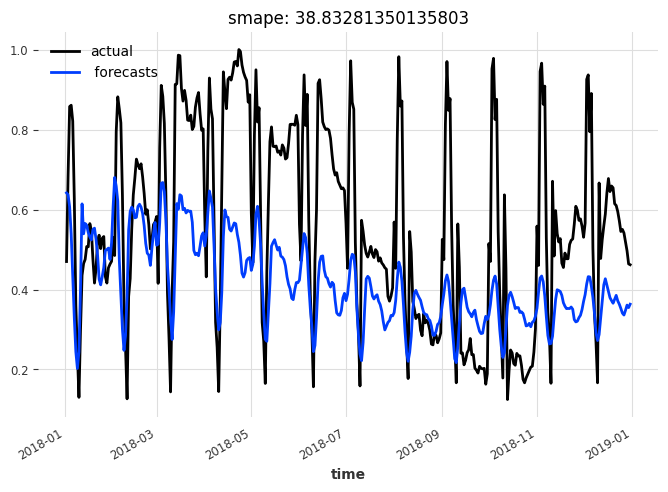

In [11]:
dlinear_pred = model_dlinear.predict(
    n = len(val), 
    series = train) 
display_forecast(dlinear_pred, series, "", start_date=pd.Timestamp("20180101"), metric = smape)

### NLinear

In [14]:
model_nlinear = NLinearModel(
    input_chunk_length=100,
    output_chunk_length=7, 
    random_state = 42, 
)

model_nlinear.fit(train, val_series=val, verbose=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | layer         | Linear           | 707   
---------------------------------------------------
707       Trainable params
0         Non-trainable params
707       Total params
0.003     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Predicting: 31it [00:00, ?it/s]

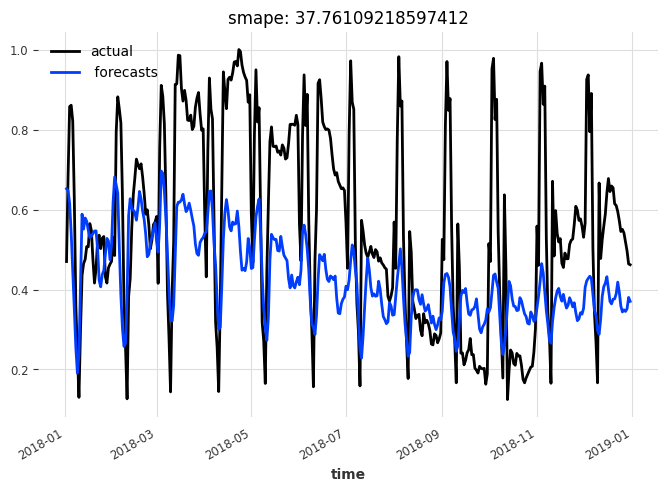

In [15]:
nlinear_pred = model_nlinear.predict(
    n = len(val), 
    series = train) 
display_forecast(nlinear_pred, series, "", start_date=pd.Timestamp("20180101"), metric = smape)

We set the hyper-parameters we want to tune in the <code>parameters</code> dictionary and we call the <code>gridsearch()</code> method for each model class. More parameters can be added to the dictionary as needed. Most importantly, we need to include the mandatory models parameters. 

In [16]:
parameters_dl = {
    "input_chunk_length" : [100, 200, 250, 300, 350], 
    "output_chunk_length": [7],
    "random_state" : [42]
}

best_dl_model, best_dl_params, min_dl_error = DLinearModel.gridsearch(parameters_dl, 
                                                                    series=train, 
                                                                    val_series = val, 
                                                                    metric=smape)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params
-----------------------------------------------------
0 | criterion       | MSELoss          | 0     
1 | train_metrics   | MetricCollection | 0     
2 | val_metrics     | MetricCollection | 0     
3 | decomposition   | _SeriesDecomp    | 0     
4 | linear_seasonal | Linear           | 707   
5 | linear_trend    | Linear           | 707   
-----------------------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.006     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Predicting: 31it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params
-----------------------------------------------------
0 | criterion       | MSELoss          | 0     
1 | train_metrics   | MetricCollection | 0     
2 | val_metrics     | MetricCollection | 0     
3 | decomposition   | _SeriesDecomp    | 0     
4 | linear_seasonal | Linear           | 1.4 K 
5 | linear_trend    | Linear           | 1.4 K 
-----------------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Predicting: 28it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params
-----------------------------------------------------
0 | criterion       | MSELoss          | 0     
1 | train_metrics   | MetricCollection | 0     
2 | val_metrics     | MetricCollection | 0     
3 | decomposition   | _SeriesDecomp    | 0     
4 | linear_seasonal | Linear           | 1.8 K 
5 | linear_trend    | Linear           | 1.8 K 
-----------------------------------------------------
3.5 K     Trainable params
0         Non-trainable params
3.5 K     Total params
0.014     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Predicting: 27it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params
-----------------------------------------------------
0 | criterion       | MSELoss          | 0     
1 | train_metrics   | MetricCollection | 0     
2 | val_metrics     | MetricCollection | 0     
3 | decomposition   | _SeriesDecomp    | 0     
4 | linear_seasonal | Linear           | 2.1 K 
5 | linear_trend    | Linear           | 2.1 K 
-----------------------------------------------------
4.2 K     Trainable params
0         Non-trainable params
4.2 K     Total params
0.017     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Predicting: 25it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params
-----------------------------------------------------
0 | criterion       | MSELoss          | 0     
1 | train_metrics   | MetricCollection | 0     
2 | val_metrics     | MetricCollection | 0     
3 | decomposition   | _SeriesDecomp    | 0     
4 | linear_seasonal | Linear           | 2.5 K 
5 | linear_trend    | Linear           | 2.5 K 
-----------------------------------------------------
4.9 K     Trainable params
0         Non-trainable params
4.9 K     Total params
0.020     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Predicting: 24it [00:00, ?it/s]

In [17]:
best_dl_model.fit(train)
pred_dl_best = best_dl_model.predict(n=len(val))

[autoreload of darts.models.forecasting.forecasting_model failed: Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_x64_test_local/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_x64_test_local/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 480, in superreload
    update_generic(old_obj, new_obj)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_x64_test_local/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 377, in update_generic
    update(a, b)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_x64_test_local/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 345, in update_class
    update_instances(old, new)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_x64_test_local/lib/python3.9/site-packages/IPytho

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Predicting: 25it [00:00, ?it/s]

# WEIRD BEHAVIOR : 
we get higher smape with the selected model and we don't retrieve the one we trained without gridsearch. It feels like the random_state is not fixing the random seeds correctly. Could that be the case, or am I missing something?

{'input_chunk_length': 300, 'output_chunk_length': 7, 'random_state': 42}


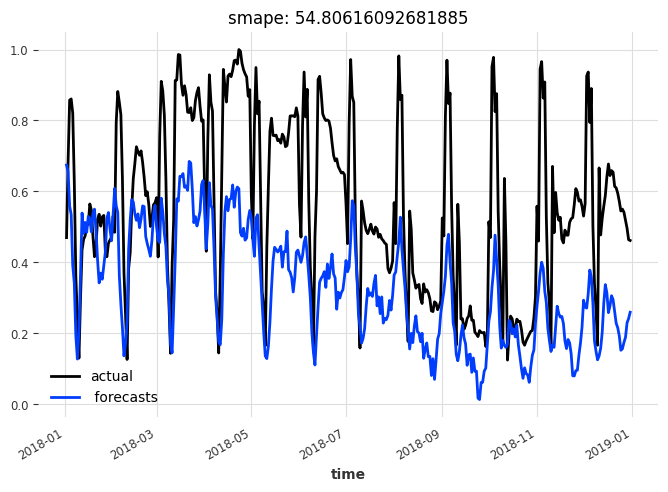

In [19]:
display_forecast(pred_dl_best, series, "", start_date=pd.Timestamp("20180101"), metric = smape)
print(best_dl_params)

In [21]:
parameters_nl = {
    "input_chunk_length" : [100, 200, 250, 300, 350], 
    "output_chunk_length": [7], 
    "random_state":[42]
}

best_nl_model, best_nl_params, min_nl_error = NLinearModel.gridsearch(parameters_nl, 
                                                                    series=train, 
                                                                    val_series = val, 
                                                                    metric=smape)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | layer         | Linear           | 707   
---------------------------------------------------
707       Trainable params
0         Non-trainable params
707       Total params
0.003     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Predicting: 31it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | layer         | Linear           | 1.4 K 
---------------------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.006     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Predicting: 28it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | layer         | Linear           | 1.8 K 
---------------------------------------------------
1.8 K     Trainable params
0         Non-trainable params
1.8 K     Total params
0.007     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Predicting: 27it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | layer         | Linear           | 2.1 K 
---------------------------------------------------
2.1 K     Trainable params
0         Non-trainable params
2.1 K     Total params
0.008     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Predicting: 25it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | layer         | Linear           | 2.5 K 
---------------------------------------------------
2.5 K     Trainable params
0         Non-trainable params
2.5 K     Total params
0.010     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Predicting: 24it [00:00, ?it/s]

In [22]:
best_nl_model.fit(train)
pred_nl_best = best_nl_model.predict(n=len(val))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | layer         | Linear           | 2.5 K 
---------------------------------------------------
2.5 K     Trainable params
0         Non-trainable params
2.5 K     Total params
0.010     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Predicting: 24it [00:00, ?it/s]

{'input_chunk_length': 350, 'output_chunk_length': 7, 'random_state': 42}


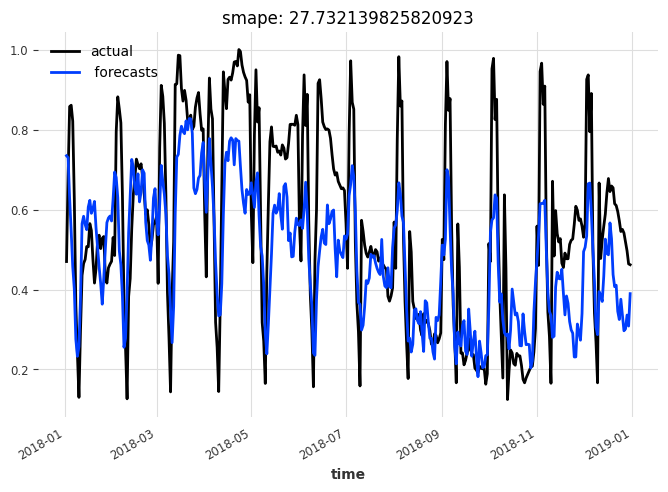

In [23]:
display_forecast(pred_nl_best, series, "", start_date=pd.Timestamp("20180101"), metric = smape)
print(best_nl_params)

## FourTheta model

We start by loading the monthly milk dataset, a dataset with an upward trend and seasonality. 

In [48]:
series = MonthlyMilkDataset().load()
train, val = series.split_after(pd.Timestamp("19740101"))

We look at the default model, before any optimization. We can look at different to estimate the out-of-sample model fit. Here we will use the Mean Absolute Error (MAE). 

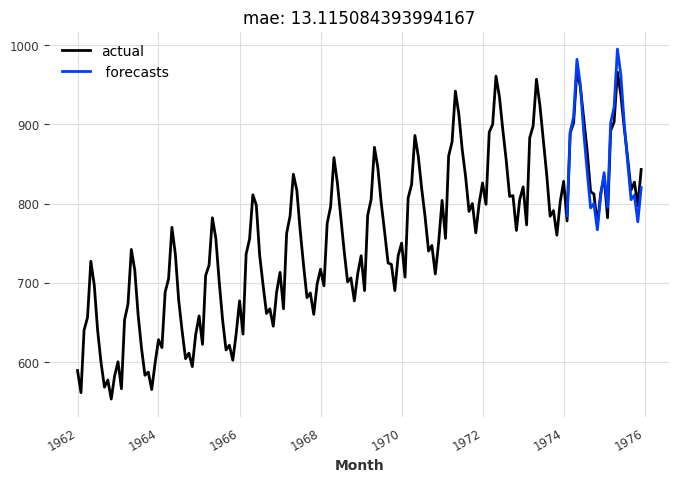

In [65]:
ftheta_model = FourTheta()
ftheta_model.fit(train)

pred_ftheta = ftheta_model.predict(n=len(val))
display_forecast(pred_ftheta, series, "", metric = mae)

We will see if we can find a model that does better than then the default one, based on the MAE metric. We will use gridsearch to go through all combinations of the FourTheta model parameters. We first construct the dictionary of parameters containing the different values for each parameter to be tested. The dictionary should contain all the parameters required by the constructor of the Darts FourTheta model along other extra arguments that can be passed to the underlying model (e.g., the Simple Exponential Smoothing (SES) model). Then we call the <code>gridseach()</code> method which returns an non-fitted instance of the model class configured with the best parameters, the best parameters that were found and the minimum error that was computed for this model. In the following case we are training on the training set and selecting the model that best performs on the validation set. We note however, that once a model is chosen with this procedure, its actual performance should be reported on a test set different from both training and validation set. 

In [66]:
parameters = {
    "theta": [1, 2, 3], 
    "model_mode" : [ModelMode.ADDITIVE, ModelMode.MULTIPLICATIVE, ModelMode.NONE], 
    "trend_mode" : [TrendMode.LINEAR, TrendMode.EXPONENTIAL], 
    "season_mode" : [SeasonalityMode.ADDITIVE, SeasonalityMode.MULTIPLICATIVE, SeasonalityMode.NONE], 
    "seasonality_period" : [None], 
    "normalization" : [True, False]
}

best_fth_model, best_fth_params, min_fth_error = FourTheta.gridsearch(parameters, series=train, val_series = val, metric=rmse)

The best model found needs to be explicitly fit by calling its <code>fit()</code> function on the training dataset. 

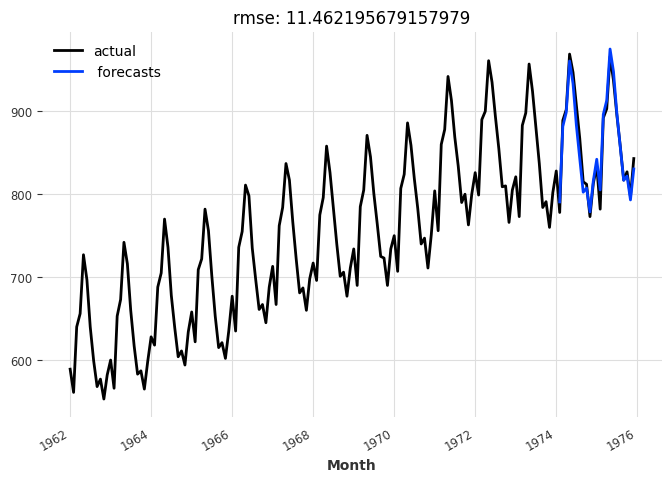

In [67]:
best_fth_model.fit(train)
pred_fth_best = best_fth_model.predict(n=len(val))
display_forecast(pred_fth_best, series, "", metric = rmse)

We see that the proposed model improved on the default one with the best parameters being the following:

In [58]:
best_params

{'theta': 3,
 'model_mode': <ModelMode.MULTIPLICATIVE: 'multiplicative'>,
 'trend_mode': <TrendMode.LINEAR: 'linear'>,
 'season_mode': <SeasonalityMode.ADDITIVE: 'additive'>,
 'seasonality_period': None,
 'normalization': True}

Note that the best model parameters are chosen based on the selected metric for comparision and are not absolute, changing the metric might change the result. In general, we advise testing with different metrics as well. Furthermore, grid search assumes that the best parameters combination is in the set of possible combinations provided by the user's values of interest, this assumption is not necessarily fullfilled if those values were selected without knowledge of the problem. Finally, the FourTheta model in Darts has a method <code>select_best_model()</code> that performs the same grid search procedure as before. However, it does not allow the selection of the comparison metric to use. 

## LightGBM
For this model we will work with the WineDataset.  
This model is based on tabular data. We can set lags from the target's past as features. LightGMB has a very large number of parameters which can be found on the model's [documentation page](https://lightgbm.readthedocs.io/en/v3.3.2/Parameters.html). We will only optimize for some of those parameters as well as the lags. 

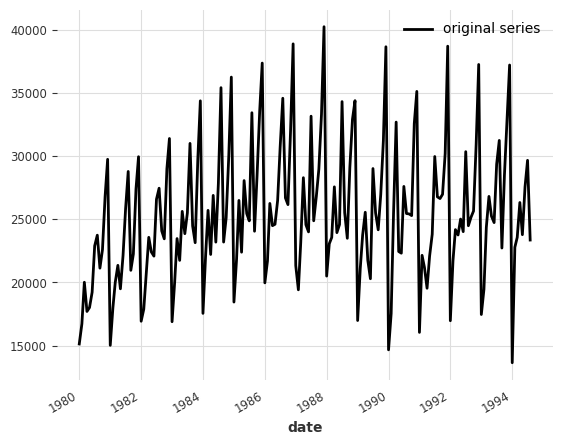

In [119]:
series = WineDataset().load()

series.plot(label='original series')


lags: [-1, -2, -3, -4, -6, -7]


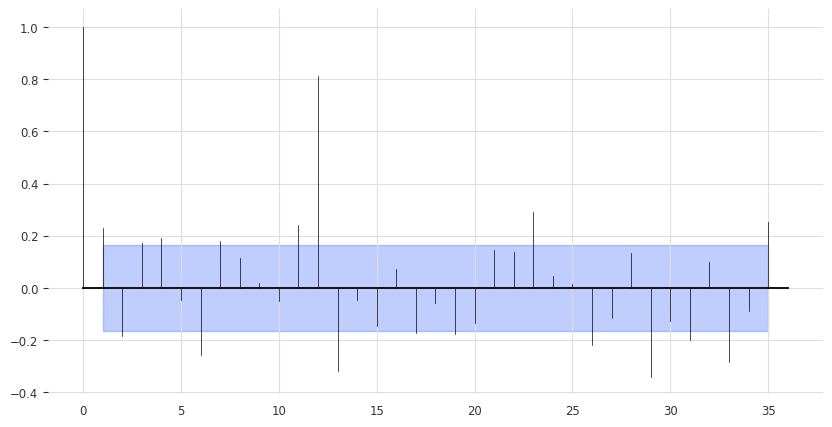

In [120]:
train, val = series.split_after(0.8)

plot_pacf(train, max_lag=len(val))
lags = get_lags(train, max_lag=(len(val)//2)) # statistically significant lags
print('lags:', lags)

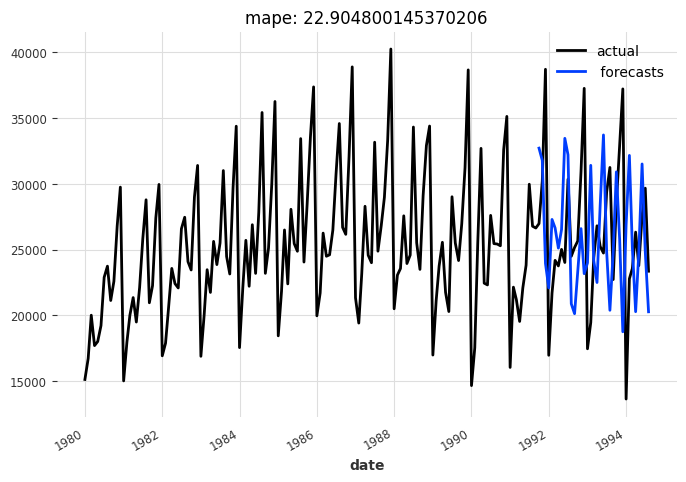

In [123]:
lgb_model = LightGBMModel(lags = lags)
lgb_model.fit(train)
pred_lgb = lgb_model.predict(len(val))

display_forecast(pred_lgb, series, "", metric = mape)


In [125]:
lgb_parameters = {'lags': [lags, lags[:-1],lags[:-2]], 'num_iterations':[100, 150, 300], 
                  'learning_rate':[0.1, 0.5], 'output_chunk_length':[1]}


best_lgb_model, best_lgb_params, min_lgb_error = LightGBMModel.gridsearch(lgb_parameters, 
                                                                          series=train, 
                                                                          val_series = val, 
                                                                          metric=mape)


/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_x64_test_local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_x64_test_local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_x64_test_local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_x64_test_local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params

/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_x64_test_local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


best parameters: {'lags': [-1, -2, -3, -4, -6], 'num_iterations': 150, 'learning_rate': 0.1, 'output_chunk_length': 1}


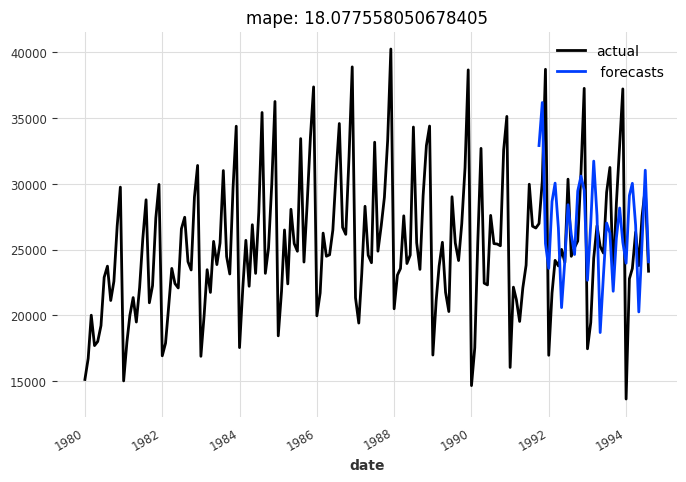

In [126]:
best_lgb_model.fit(train)
pred_lgb_best = best_lgb_model.predict(len(val))

display_forecast(pred_lgb_best, series, "", metric = mape)

print('best parameters:', best_lgb_params)


# Finally 
Darts grid search has three modes of operation:
* Expanding window mode (activated when `forecast_horizon` is passed):
  For every hyperparameter combination, the model is repeatedly trained and evaluated on different splits of `series`. 
* Split window mode (activated when `val_series` is passed): 
  This mode will be used when the `val_series` argument is passed.
  For every hyper-parameter combination, the model is trained on `series` and evaluated on `val_series`.
* Fitted value mode (activated when `use_fitted_values` is set to `True`):
  For every hyper-parameter combination, the model is trained on `series` and evaluated on the resulting fitted values, if those are present in the model.
